pixel&weight, polynomial regression

In [ ]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import datasets
import pandas as pd
%matplotlib inline
import io
import json
import csv
import os
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/뱀장어 평균 중량인식 공모전/data/dataset')

Mounted at /content/drive


In [ ]:
# train 폴더목록 불러오기
folder_list = os.listdir('./train')
folder_list.sort()

#'한 영상 안에서의 뱀장어의 평균 pixel개수' list
pxnum_video=[]
Area_list_video=[]
# train 폴더 내 json파일 목록 불러오기
for folder in folder_list:
  path = './train/' + folder
  train_folder_list = os.listdir(path)
  train_folder_list.sort()

  # jpg 파일만 불러오기
  jpg_file_list = [file for file in train_folder_list if file.endswith('.jpg')]
  # json 파일만 불러오기
  json_file_list = [file for file in train_folder_list if file.endswith('.json')]

  dict = {}
  #'한 jpg파일 안의 뱀장어 n마리의 평균 pixel개수' list
  pxnum_jpg=[]
  Area_list_json=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list:
    with open((path + '/' + json_file),'r') as f:
      dict = json.load(f)

    #'한 json파일 안에서 선별된 뱀장어 n마리의 각각의 pixel개수' list
    pxnum_n = []
    Area_list_n = []
    for poly_num in range(len(dict['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict['data'][poly_num]['x']
      y_point = dict['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      #area 구하기
      area=PolyArea(x_point,y_point)
      Area_list_n.append(area)
      Area=int(area)
      #json파일에 해당하는 이미지 불러오기
      jsonnumber=json_file.rstrip('.json')
      img = Image.open(path+'/'+jsonnumber+".jpg")
      #그 area만큼 같은 이미지를 crop하기. 
      croppedimg=img.crop((0,0,Area,1)) 
      #그 area만큼의 pixel개수 구하기
      img_size_cropped = croppedimg.size
      pxnum=img_size_cropped[0]*img_size_cropped[1]
      pxnum_n.append(pxnum)
    avg_pxnum_n = sum(pxnum_n)/len(pxnum_n)
    pxnum_jpg.append(avg_pxnum_n)
    avg_area_n = sum(Area_list_n)/len(Area_list_n)
    Area_list_json.append(avg_area_n)
  avg_pxnum_jpg = sum(pxnum_jpg)/len(pxnum_jpg)
  pxnum_video.append(avg_pxnum_jpg)
  avg_area_json = sum(Area_list_json)/len(Area_list_json)
  Area_list_video.append(avg_area_json)

In [ ]:
px_list_video=[x**1.5 for x in pxnum_video]
volumn_list_video=[x**1.5 for x in Area_list_video]

train 124개 폴더의 평균 중량값 얻기

In [ ]:
train_csv = pd.read_csv('./train.csv')
#train_csv 정렬
train_csv=train_csv.sort_values(by='ImageDir', ascending=True)

In [ ]:
AvgWeight = train_csv.loc[:, 'AvgWeight']
AvgWeight

19     72.089286
117    95.033696
8      27.564475
60     45.250000
110    21.020000
         ...    
24     55.283333
123    27.598478
44     47.373636
120    28.102391
29     27.009400
Name: AvgWeight, Length: 124, dtype: float64

산점도 그리기

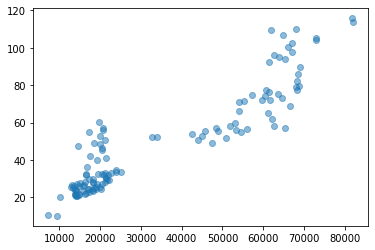

In [ ]:
pxVol = torch.Tensor(px_list_video)
Weight = torch.Tensor(AvgWeight)
x_train = pxVol  # X for model training
x_train = x_train.reshape(-1,1)
y_train = Weight   # y label

plt.scatter(x_train, y_train, alpha=0.5)

model import

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)

LinearRegression()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(x_train)
poly_reg.fit(X_poly, y_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)

LinearRegression()

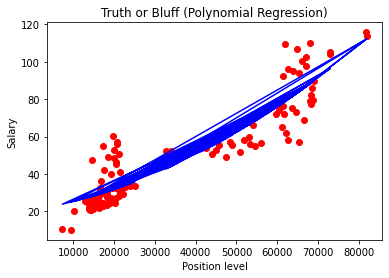

In [ ]:
plt.scatter(x_train, y_train, color = 'red')
plt.plot(x_train, lin_reg_2.predict(poly_reg.fit_transform(x_train)), color = 'blue')
plt.title('Truth or Bluff (Polynomial Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

x_test만들기

In [ ]:
# test 폴더목록 불러오기
folder_list = os.listdir('./test')
folder_list.sort()

#'한 영상 안에서의 뱀장어의 평균 pixel개수' list
pxnum_video=[]
Area_list_video=[]
# train 폴더 내 json파일 목록 불러오기
for folder in folder_list:
  path = './test/' + folder
  test_folder_list = os.listdir(path)
  test_folder_list.sort()

  # jpg 파일만 불러오기
  jpg_file_list = [file for file in test_folder_list if file.endswith('.jpg')]
  # json 파일만 불러오기
  json_file_list = [file for file in test_folder_list if file.endswith('.json')]

  dict = {}
  #'한 jpg파일 안의 뱀장어 n마리의 평균 pixel개수' list
  pxnum_jpg=[]
  Area_list_json=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list:
    with open((path + '/' + json_file),'r') as f:
      dict = json.load(f)
      #print(dict)

    #'한 json파일 안에서 선별된 뱀장어 n마리의 각각의 pixel개수' list
    pxnum_n = []
    Area_list_n = []
    for poly_num in range(len(dict['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict['data'][poly_num]['x']
      y_point = dict['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      #area 구하기
      area=PolyArea(x_point,y_point)
      Area_list_n.append(area)
      Area=int(area)
      #json파일에 해당하는 이미지 불러오기
      jsonnumber=json_file.rstrip('.json')
      img = Image.open(path+'/'+jsonnumber+".jpg")
      #그 area만큼 같은 이미지를 crop하기. 시작점은 중간, 너비는 넓이를 고려해서
      croppedimg=img.crop((0,0,Area,1))
      #그 area만큼의 pixel개수 구하기
      img_size_cropped = croppedimg.size
      pxnum=img_size_cropped[0]*img_size_cropped[1]
      pxnum_n.append(pxnum)
    avg_pxnum_n = sum(pxnum_n)/len(pxnum_n)
    pxnum_jpg.append(avg_pxnum_n)
    avg_area_n = sum(Area_list_n)/len(Area_list_n)
    Area_list_json.append(avg_area_n)
  avg_pxnum_jpg = sum(pxnum_jpg)/len(pxnum_jpg)
  pxnum_video.append(avg_pxnum_jpg)
  avg_area_json = sum(Area_list_json)/len(Area_list_json)
  Area_list_video.append(avg_area_json)

In [ ]:
px_list_video=[x**1.5 for x in pxnum_video]
volumn_list_video=[x**1.5 for x in Area_list_video]

In [ ]:
pxvol= torch.Tensor(px_list_video)
x_test = pxvol  # X for model training
x_test = x_test.reshape(-1,1)

예측하기

In [ ]:
predictions=lin_reg_2.predict(poly_reg.fit_transform(x_test))

csv파일 만들기

In [ ]:
data = {'ImageDir':folder_list, 'AvgWeight':predictions}
df = pd.DataFrame(data)
df

,ImageDir,AvgWeight
0,1I2EkxetCZ,29.692005
1,31PsozUNAW,92.377095
2,3AT4ivS98X,31.381662
3,49UmJQBya0,29.725235
4,4SJmIOpm84,29.410820
...,...,...
80,xZQH4hLHot,29.988990
81,xwlBbazGdz,35.816799
82,ya75FdleJX,87.846799
83,yyYdnAwplY,86.544411


In [ ]:
csv_path = '/content/drive/MyDrive/뱀장어'
df.to_csv(csv_path+'/test.csv')